# Analyze Received Long Multi Tone Calibration WAV File
## By Terry Bondy, VA3TYB

In [1]:
printf(strftime ("Last updated: %A %e %B %Y %Z", localtime (time())))
%plot --format svg
format free
pkg load signal

Last updated: Saturday 18 January 2020 UTC

In [2]:
sampleRate = 8000
T = 0:1/sampleRate:5;

sampleRate = 8000


In [3]:
PilotFreq1 = 719;
PilotFreq2 = 721;
PilotFreq3 = 724;
SamplesRV = (cos(2*pi*PilotFreq1 * T) .+ cos(2*pi*PilotFreq2 * T) .+ cos(2*pi*PilotFreq3 * T))(:);
size(SamplesRV)

ans =

 40001 1




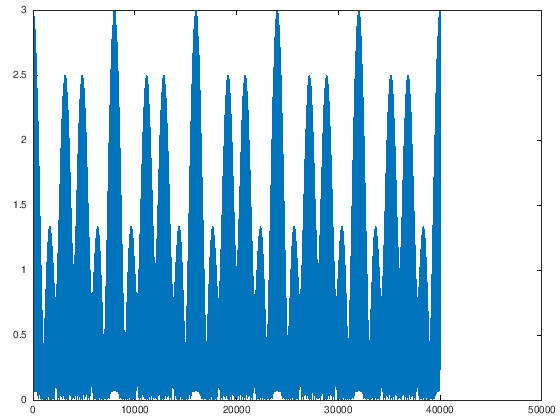

In [4]:
plot(abs(SamplesRV));

In [5]:
rows(SamplesRV)
numPeriods = (rows(SamplesRV)-1)/sampleRate
period = numPeriods
TshortRV = [0:1/sampleRate:(numPeriods-2)](:);
TfullRV = [0:1/sampleRate:period](:);

ans = 40001
numPeriods = 5
period = 5


In [6]:
RaisedCosineRV = (1 - cos(2*pi*TshortRV/(numPeriods-2)))/2;
size(RaisedCosineRV)

ans =

 24001 1




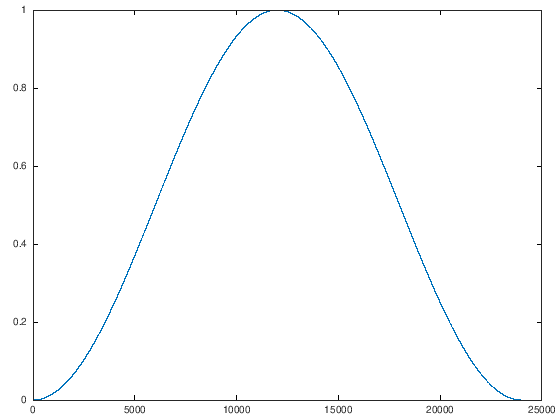

In [7]:
plot(RaisedCosineRV)

In [8]:
SigSec0RV = SamplesRV(1:rows(RaisedCosineRV)) .* RaisedCosineRV;
size(SigSec0RV)

ans =

 24001 1




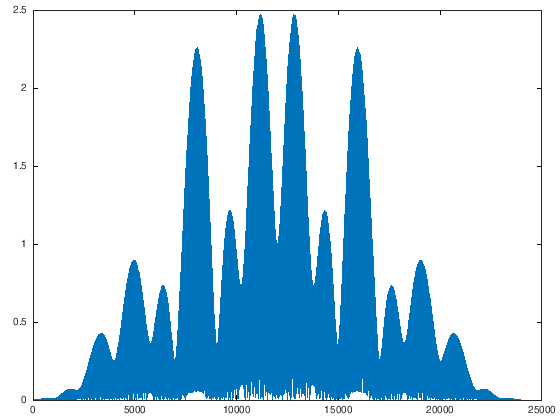

In [9]:
plot(abs(SigSec0RV));

In [10]:
FftSec0RV = abs(fftshift(fft(SigSec0RV, (rows(RaisedCosineRV)-1)*10 + 1)));
FreqSec0RV = [linspace(-sampleRate/2, sampleRate/2, rows(FftSec0RV))](:);

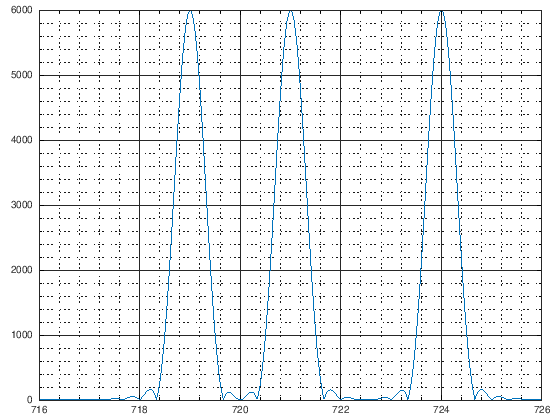

In [11]:
plot(FreqSec0RV, FftSec0RV)
grid on
grid minor
axis([PilotFreq2-5 PilotFreq2+5], "tic")

In [12]:
fracSeconds = 100;
indexIncr = sampleRate/fracSeconds;
rows(SamplesRV)-rows(RaisedCosineRV)-1;
pilotFreq = PilotFreq3;
Response = [];
# Use a most positive initial reference freq because probe freq starts low and increases
refFreq = PilotFreq3;
for startIndex = 1:indexIncr:rows(SamplesRV)-rows(RaisedCosineRV)-1
  time = TfullRV(startIndex);
  # SigSec0RV = SamplesRV(1:rows(RaisedCosineRV)) .* RaisedCosineRV;
  SigLoopRV = SamplesRV(startIndex:startIndex+rows(RaisedCosineRV)-1) .* RaisedCosineRV;
  FftLoopRV = fftshift(fft(SigLoopRV, (rows(RaisedCosineRV)-1)*10 + 1));
  FftLoopAbsRV = abs(FftLoopRV);
  # max(FftLoopAbsRV)
  # FftLoopPolCV = cart2pol(real(FftLoopRV), imag(FftLoopRV)); # rows of [theta, r]
  # FftLoopPolCV(1,:)
  FreqLoopRV = linspace(-sampleRate/2, sampleRate/2, rows(FftLoopRV));
  freqMaxPeak = FreqLoopRV(find(FftLoopAbsRV(:) == max(FftLoopAbsRV)));
  [PeaksCV idxPeaksCV] = findpeaks(FftLoopAbsRV, "MinPeakHeight", 500);
  if (rows(idxPeaksCV) == 1)
    idxPeaksCV = [idxPeaksCV; idxPeaksCV];
  endif
  FreqPeaksLoopRV = FreqLoopRV(idxPeaksCV);
  # Find the reference frequency based on minimum difference from the last iteration
  FreqDiff = abs(FreqPeaksLoopRV .- refFreq);
  minFreqDiff = min(FreqDiff);
  refFreqIdx = find(FreqDiff(:) == minFreqDiff, 1);
  probeFreq1Idx = refFreqIdx - 1;
  probeFreq2Idx = refFreqIdx - 2;
  # Determine corrected (expected) frequencies
  corrFreqLoopRV = FreqPeaksLoopRV .- FreqPeaksLoopRV(refFreqIdx) .+ pilotFreq;
  # Get ratio of response
  probeFreq1Response = FftLoopRV(idxPeaksCV(probeFreq1Idx))/FftLoopRV(idxPeaksCV(refFreqIdx));
  probeFreq2Response = FftLoopRV(idxPeaksCV(probeFreq2Idx))/FftLoopRV(idxPeaksCV(refFreqIdx));
  [phase1, mag1] = cart2pol(real(probeFreq1Response), imag(probeFreq1Response)); # rows of [theta, r]
  [phase2, mag2] = cart2pol(real(probeFreq2Response), imag(probeFreq2Response)); # rows of [theta, r]
  Response = [Response; time, corrFreqLoopRV(probeFreq1Idx), phase1*180/pi, corrFreqLoopRV(probeFreq2Idx), phase2*180/pi, abs(phase1*180/pi) * abs(phase2*180/pi)];
  # Response1 = [Response1; time, rows(idxPeaksCV), corrFreqLoopRV(probeFreq1Idx), phase1*180/pi, 20*log10(mag1)];
  # Response2 = [Response2; time, rows(idxPeaksCV), corrFreqLoopRV(probeFreq2Idx), phase2*180/pi, 20*log10(mag2)];
  
  # Compute the new reference frequency
  refFreq = FreqPeaksLoopRV(refFreqIdx);
endfor

In [14]:
format short
printf( ...
"     time        peaks     probeFreq    Phase (deg)  Mag(log)\n")
Response

     time        peaks     probeFreq    Phase (deg)  Mag(log)
Response =

   0.0000e+00   7.2100e+02  -6.7500e-03   7.1900e+02  -1.1250e-02   7.5937e-05
   1.0000e-02   7.2100e+02  -1.0807e+01   7.1900e+02  -1.8011e+01   1.9465e+02
   2.0000e-02   7.2100e+02  -2.1607e+01   7.1900e+02  -3.6012e+01   7.7811e+02
   3.0000e-02   7.2100e+02  -3.2408e+01   7.1900e+02  -5.4012e+01   1.7504e+03
   4.0000e-02   7.2100e+02  -4.3208e+01   7.1900e+02  -7.2012e+01   3.1115e+03
   5.0000e-02   7.2100e+02  -5.4008e+01   7.1900e+02  -9.0012e+01   4.8614e+03
   6.0000e-02   7.2100e+02  -6.4808e+01   7.1900e+02  -1.0801e+02   7.0001e+03
   7.0000e-02   7.2100e+02  -7.5609e+01   7.1900e+02  -1.2601e+02   9.5276e+03
   8.0000e-02   7.2100e+02  -8.6409e+01   7.1900e+02  -1.4401e+02   1.2444e+04
   9.0000e-02   7.2100e+02  -9.7209e+01   7.1900e+02  -1.6201e+02   1.5749e+04
   1.0000e-01   7.2100e+02  -1.0801e+02   7.1900e+02   1.7999e+02   1.9440e+04
   1.1000e-01   7.2100e+02  -1.1881e+02   7.1900e+02   1.